# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm
import itertools
from datetime import datetime

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [2]:
train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

In [5]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [4]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [6]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]
xy_out = train_data[:, :, 51:, :2].reshape(-1, 2)
# only find the x, y != 0
xy_out_not_0 = xy_out[(xy_out[:, 0] != 0) & (xy_out[:, 1] != 0)]

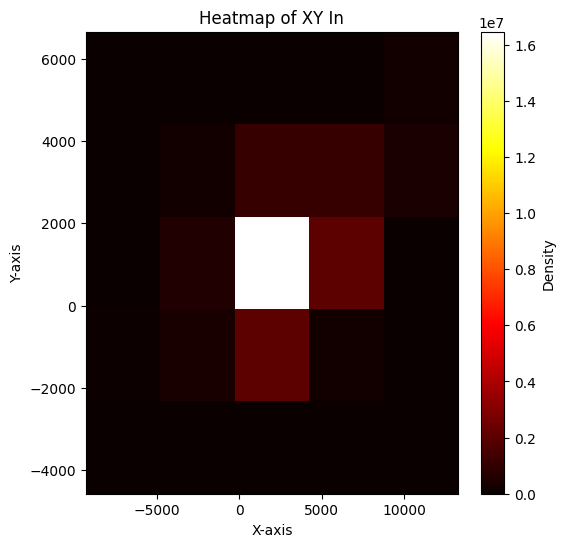

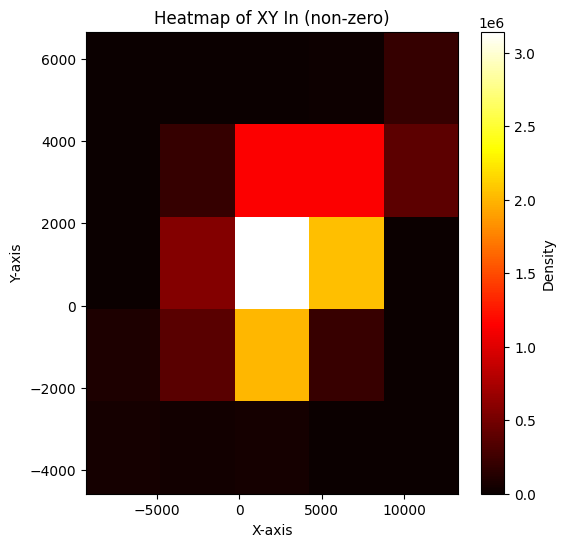

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

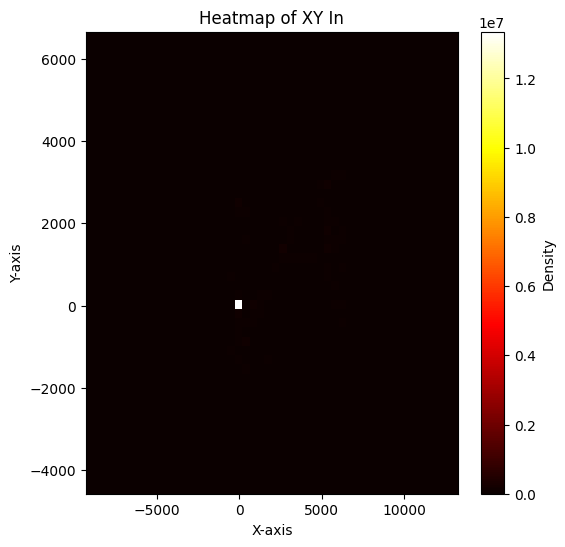

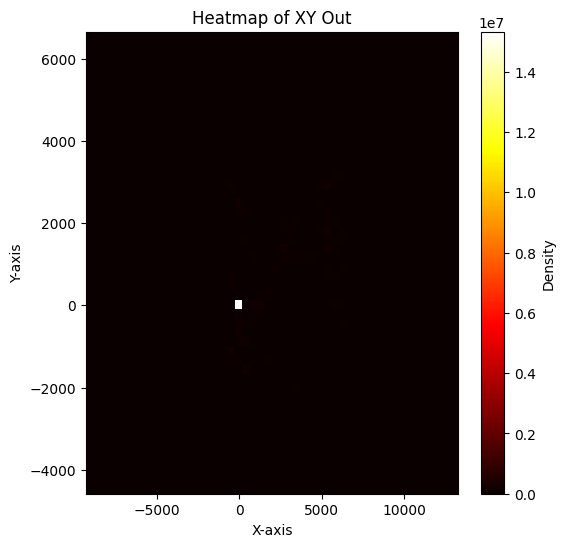

In [8]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_out, title='Heatmap of XY Out', bins=50)

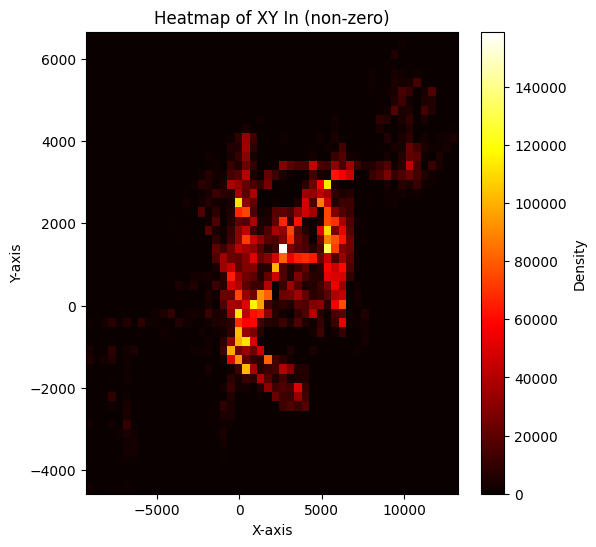

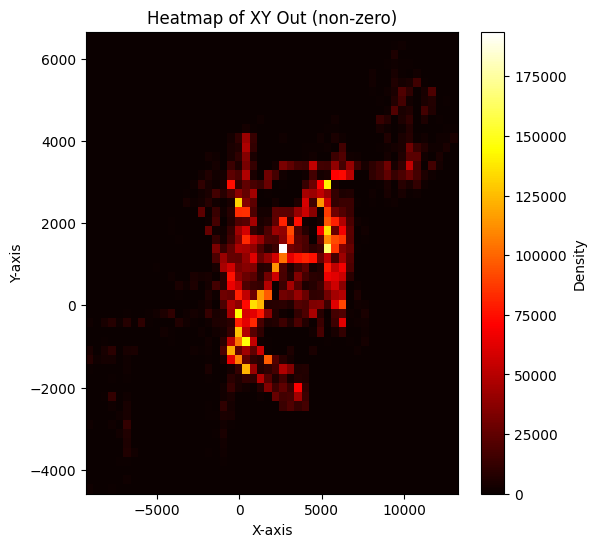

In [9]:
plot_heatmap(xy_in_not_0, title="Heatmap of XY In (non-zero)", bins=50)
plot_heatmap(xy_out_not_0, title="Heatmap of XY Out (non-zero)", bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

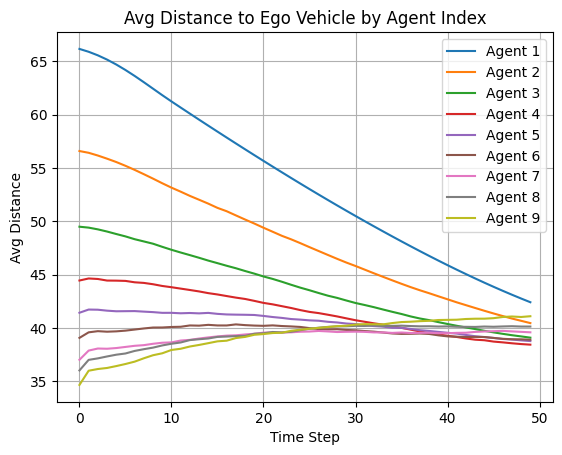

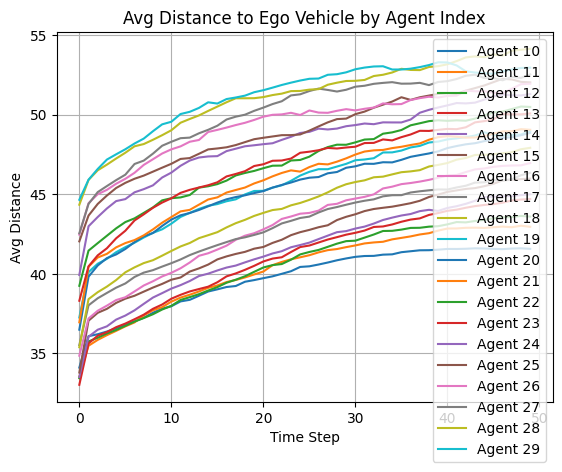

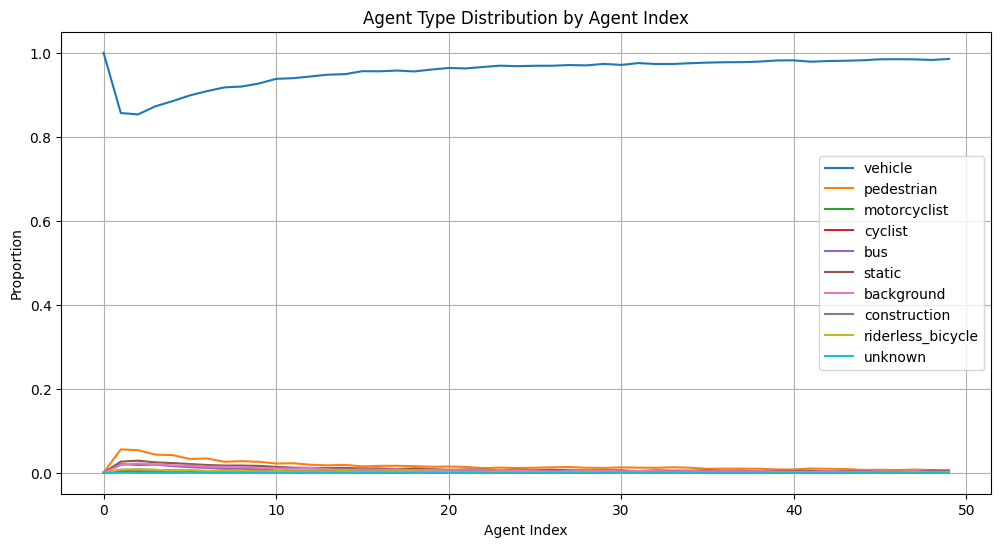

In [8]:
# 1. Autoregressive distance plot
def average_distance_to_ego(data, start_agent=1, max_agents=10):
    distances = []
    for i in range(start_agent, max_agents):  # agent 0 is ego
        dist = np.linalg.norm(data[:, i, :50, :2] - data[:, 0, :50, :2], axis=-1)  # shape: (scenes, time)
        # Mask out padded zeros
        valid_mask = np.logical_and(data[:, i, :50, 0] != 0, data[:, i, :50, 1] != 0)
        mean_dist = np.sum(dist * valid_mask, axis=0) / np.sum(valid_mask, axis=0)
        distances.append(mean_dist)

    distances = np.array(distances)
    for i in range(distances.shape[0]):
        plt.plot(distances[i], label=f'Agent {i+start_agent}')
    plt.title("Avg Distance to Ego Vehicle by Agent Index")
    plt.xlabel("Time Step")
    plt.ylabel("Avg Distance")
    plt.legend()
    plt.grid()
    plt.show()

average_distance_to_ego(train_data, max_agents=10)

average_distance_to_ego(train_data, start_agent=10, max_agents=30)

# 2. Agent type distribution by index
object_type_counts = np.zeros((50, 10))  # agent index x object type

for i in range(50):
    types = train_data[:, i, 0, 5]  # take type from first timestep
    for t in range(10):
        object_type_counts[i, t] += np.sum(types == t)

object_labels = ['vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus', 'static', 'background', 'construction', 'riderless_bicycle', 'unknown']
object_type_counts_norm = object_type_counts / object_type_counts.sum(axis=1, keepdims=True)

plt.figure(figsize=(12, 6))
for t in range(10):
    plt.plot(object_type_counts_norm[:, t], label=object_labels[t])
plt.title("Agent Type Distribution by Agent Index")
plt.xlabel("Agent Index")
plt.ylabel("Proportion")
plt.legend()
plt.grid()
plt.show()


Insights:

-Lower index agents tends to be closer in proximity to ego agent. Possible that indexes are ranked by impact on to ego agent per scenario.
-Most (around 90-95%) of agents are vehicles. Lower indices are around 5-10% less vehicles and more pedestrians or static/background

## Step 3: Setting up the Training and Testing

### Example Code:

In [173]:
class TrajectoryDatasetTrainAll(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()  # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[:, 50:, :2].copy(), dtype=torch.float32)  # (50, 60, 2)

        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array(
                    [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]],
                    dtype=np.float32,
                )
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item

In [172]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)

        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item


class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [174]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
train_dataset_all = TrajectoryDatasetTrainAll(
    train_data[:train_size], scale=scale, augment=True
)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
train_dataloader_all = DataLoader(
    train_dataset_all,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda x: Batch.from_data_list(x),
)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [78]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [79]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6) # extend batch out to 4 dim
        x = x[:, :, :, :] # (batch, 50, 50, 6)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [13]:
class LSTM(nn.Module):
    def __init__(
        self, input_dim=6, hidden_dim=128, num_layers=1, dropout=0.0, output_dim=60 * 2
    ):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only Consider ego agent index 0
        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [12]:
class GRU(nn.Module):
    def __init__(
        self, input_dim=6, hidden_dim=128, num_layers=1, dropout=0.0, output_dim=60 * 2
    ):
        super(GRU, self).__init__()
        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only Consider ego agent index 0
        lstm_out, _ = self.gru(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

Train LSTM On All Agents

In [159]:
class LSTM_ALL(nn.Module):
    def __init__(
        self, input_dim=6, hidden_dim=128, num_layers=1, dropout=0.0, output_dim=60 * 2
    ):
        super(LSTM_ALL, self).__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        out = torch.empty(x.shape[0], 50, 120).to(device)
        for agent in range(50):
            agent_x = x[:, agent, :, :]
            lstm_out, _ = self.lstm(agent_x)
            # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
            out_agent = self.fc(lstm_out[:, -1, :])
            out[:, agent, :] = out_agent
        return out.view(-1, 50, 60, 2)

In [190]:
class LSTM_STACK(nn.Module):
    def __init__(
        self, input_dim=6, hidden_dim=128, num_layers=1, dropout=0.0, output_dim=60
    ):
        super(LSTM_STACK, self).__init__()
        self.lstm1 = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )
        self.lstm2 = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )
        self.fc1 = nn.Linear(hidden_dim, output_dim*6)
        self.fc2 = nn.Linear(hidden_dim, output_dim*2)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only Consider ego agent index 0
        lstm_out, _ = self.lstm1(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc1(lstm_out[:, -1, :])
        initial_pred = out.view(-1, 60, 6)

        x_stack = torch.cat((x, initial_pred), dim=1) # Should be shape (batch_size, full_seq_len, input_dim)
        lstm_out_stack, _ = self.lstm2(x_stack)
        # lstm_out is of shape (batch_size, full_seq_len, hidden_dim) and we want the last time step output
        out_stack = self.fc2(lstm_out_stack[:, -1, :])
        return out_stack.view(-1, 60, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [279]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTM(hidden_dim=48).to(device)
# model = GRU(hidden_dim=128).to(device)
# model = LSTM_ALL().to(device)
# model = LSTM_STACK(hidden_dim=64).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
early_stopping_patience = 8
best_val_loss = float('inf')
criterion = nn.MSELoss()

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [213]:
all_train_flag = False

In [280]:
if all_train_flag:
    current_dataloader = train_dataloader_all
else:
    current_dataloader = train_dataloader

no_improvement = 0
for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in current_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        if all_train_flag:
            y = batch.y.view(batch.num_graphs, 50, 60, 2)
        else:
            y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            if all_train_flag:
                pred = model(batch)[:, 0, :, :]
            else:
                pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    scheduler.step()
    # scheduler.step(val_loss)

    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/d_/qt9yhc2549s7ghqsdf91y2l40000gn/T/ipykernel_56110/3481863658.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/d_/qt9yhc2549s7ghqsdf91y2l40000gn/T/ipykernel_56110/3481863658.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/100 [00:05<08:30,  5.16s/epoch]

Epoch 000 | Learning rate 0.010000 | train normalized MSE   0.8667 | val normalized MSE   0.3938, | val MAE   2.3224 | val MSE  19.2960


Epoch:   2%|▏         | 2/100 [00:09<07:55,  4.85s/epoch]

Epoch 001 | Learning rate 0.010000 | train normalized MSE   0.3766 | val normalized MSE   0.3349, | val MAE   2.1206 | val MSE  16.4102


Epoch:   3%|▎         | 3/100 [00:14<07:39,  4.74s/epoch]

Epoch 002 | Learning rate 0.010000 | train normalized MSE   0.3481 | val normalized MSE   0.3199, | val MAE   2.0659 | val MSE  15.6765


Epoch:   4%|▍         | 4/100 [00:18<07:29,  4.68s/epoch]

Epoch 003 | Learning rate 0.010000 | train normalized MSE   0.3196 | val normalized MSE   0.2902, | val MAE   2.1200 | val MSE  14.2222


Epoch:   5%|▌         | 5/100 [00:23<07:23,  4.66s/epoch]

Epoch 004 | Learning rate 0.010000 | train normalized MSE   0.2881 | val normalized MSE   0.2657, | val MAE   1.8654 | val MSE  13.0182


Epoch:   6%|▌         | 6/100 [00:28<07:17,  4.66s/epoch]

Epoch 005 | Learning rate 0.010000 | train normalized MSE   0.2702 | val normalized MSE   0.3194, | val MAE   2.1932 | val MSE  15.6482


Epoch:   7%|▋         | 7/100 [00:32<07:10,  4.63s/epoch]

Epoch 006 | Learning rate 0.010000 | train normalized MSE   0.2939 | val normalized MSE   0.2582, | val MAE   1.8376 | val MSE  12.6507


Epoch:   8%|▊         | 8/100 [00:37<07:01,  4.58s/epoch]

Epoch 007 | Learning rate 0.010000 | train normalized MSE   0.2516 | val normalized MSE   0.2180, | val MAE   1.6384 | val MSE  10.6806


Epoch:   9%|▉         | 9/100 [00:41<06:44,  4.45s/epoch]

Epoch 008 | Learning rate 0.010000 | train normalized MSE   0.2391 | val normalized MSE   0.2261, | val MAE   1.7181 | val MSE  11.0800


Epoch:  10%|█         | 10/100 [00:45<06:32,  4.36s/epoch]

Epoch 009 | Learning rate 0.010000 | train normalized MSE   0.2303 | val normalized MSE   0.2132, | val MAE   1.6700 | val MSE  10.4454


Epoch:  11%|█         | 11/100 [00:49<06:27,  4.35s/epoch]

Epoch 010 | Learning rate 0.010000 | train normalized MSE   0.2246 | val normalized MSE   0.2061, | val MAE   1.5872 | val MSE  10.0981


Epoch:  12%|█▏        | 12/100 [00:54<06:18,  4.31s/epoch]

Epoch 011 | Learning rate 0.010000 | train normalized MSE   0.2226 | val normalized MSE   0.2052, | val MAE   1.5427 | val MSE  10.0525


Epoch:  13%|█▎        | 13/100 [00:58<06:11,  4.27s/epoch]

Epoch 012 | Learning rate 0.010000 | train normalized MSE   0.2245 | val normalized MSE   0.2057, | val MAE   1.6398 | val MSE  10.0772


Epoch:  14%|█▍        | 14/100 [01:02<06:05,  4.25s/epoch]

Epoch 013 | Learning rate 0.010000 | train normalized MSE   0.2154 | val normalized MSE   0.1924, | val MAE   1.5468 | val MSE   9.4290


Epoch:  15%|█▌        | 15/100 [01:06<05:58,  4.22s/epoch]

Epoch 014 | Learning rate 0.010000 | train normalized MSE   0.2092 | val normalized MSE   0.2000, | val MAE   1.5623 | val MSE   9.7997


Epoch:  16%|█▌        | 16/100 [01:10<05:53,  4.21s/epoch]

Epoch 015 | Learning rate 0.010000 | train normalized MSE   0.2387 | val normalized MSE   0.2097, | val MAE   1.5933 | val MSE  10.2767


Epoch:  17%|█▋        | 17/100 [01:15<05:49,  4.21s/epoch]

Epoch 016 | Learning rate 0.010000 | train normalized MSE   0.2159 | val normalized MSE   0.1992, | val MAE   1.5624 | val MSE   9.7625


Epoch:  18%|█▊        | 18/100 [01:19<05:55,  4.33s/epoch]

Epoch 017 | Learning rate 0.010000 | train normalized MSE   0.2089 | val normalized MSE   0.2032, | val MAE   1.5552 | val MSE   9.9559


Epoch:  19%|█▉        | 19/100 [01:24<05:55,  4.39s/epoch]

Epoch 018 | Learning rate 0.010000 | train normalized MSE   0.2072 | val normalized MSE   0.2263, | val MAE   1.6956 | val MSE  11.0880


Epoch:  20%|██        | 20/100 [01:28<05:56,  4.46s/epoch]

Epoch 019 | Learning rate 0.002500 | train normalized MSE   0.2058 | val normalized MSE   0.1955, | val MAE   1.5576 | val MSE   9.5818


Epoch:  21%|██        | 21/100 [01:33<05:53,  4.48s/epoch]

Epoch 020 | Learning rate 0.002500 | train normalized MSE   0.1880 | val normalized MSE   0.1779, | val MAE   1.3825 | val MSE   8.7191


Epoch:  22%|██▏       | 22/100 [01:38<05:52,  4.52s/epoch]

Epoch 021 | Learning rate 0.002500 | train normalized MSE   0.1836 | val normalized MSE   0.1800, | val MAE   1.3945 | val MSE   8.8204


Epoch:  23%|██▎       | 23/100 [01:42<05:50,  4.55s/epoch]

Epoch 022 | Learning rate 0.002500 | train normalized MSE   0.1830 | val normalized MSE   0.1794, | val MAE   1.3897 | val MSE   8.7900


Epoch:  24%|██▍       | 24/100 [01:47<05:44,  4.54s/epoch]

Epoch 023 | Learning rate 0.002500 | train normalized MSE   0.1831 | val normalized MSE   0.1761, | val MAE   1.4032 | val MSE   8.6310


Epoch:  25%|██▌       | 25/100 [01:51<05:36,  4.48s/epoch]

Epoch 024 | Learning rate 0.002500 | train normalized MSE   0.1820 | val normalized MSE   0.1792, | val MAE   1.3990 | val MSE   8.7798


Epoch:  26%|██▌       | 26/100 [01:55<05:29,  4.45s/epoch]

Epoch 025 | Learning rate 0.002500 | train normalized MSE   0.1817 | val normalized MSE   0.1783, | val MAE   1.3967 | val MSE   8.7375


Epoch:  27%|██▋       | 27/100 [02:00<05:22,  4.42s/epoch]

Epoch 026 | Learning rate 0.002500 | train normalized MSE   0.1821 | val normalized MSE   0.1842, | val MAE   1.4734 | val MSE   9.0236


Epoch:  28%|██▊       | 28/100 [02:04<05:16,  4.40s/epoch]

Epoch 027 | Learning rate 0.002500 | train normalized MSE   0.1801 | val normalized MSE   0.1834, | val MAE   1.3972 | val MSE   8.9885


Epoch:  29%|██▉       | 29/100 [02:08<05:11,  4.38s/epoch]

Epoch 028 | Learning rate 0.002500 | train normalized MSE   0.1804 | val normalized MSE   0.1792, | val MAE   1.3901 | val MSE   8.7816


Epoch:  30%|███       | 30/100 [02:13<05:03,  4.33s/epoch]

Epoch 029 | Learning rate 0.002500 | train normalized MSE   0.1798 | val normalized MSE   0.1823, | val MAE   1.3997 | val MSE   8.9346


Epoch:  31%|███       | 31/100 [02:17<04:59,  4.33s/epoch]

Epoch 030 | Learning rate 0.002500 | train normalized MSE   0.1809 | val normalized MSE   0.1831, | val MAE   1.4659 | val MSE   8.9712


Epoch:  31%|███       | 31/100 [02:21<05:15,  4.58s/epoch]

Epoch 031 | Learning rate 0.002500 | train normalized MSE   0.1788 | val normalized MSE   0.1763, | val MAE   1.4051 | val MSE   8.6367
Early stop!


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [281]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

/var/folders/d_/qt9yhc2549s7ghqsdf91y2l40000gn/T/ipykernel_56110/3481863658.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin


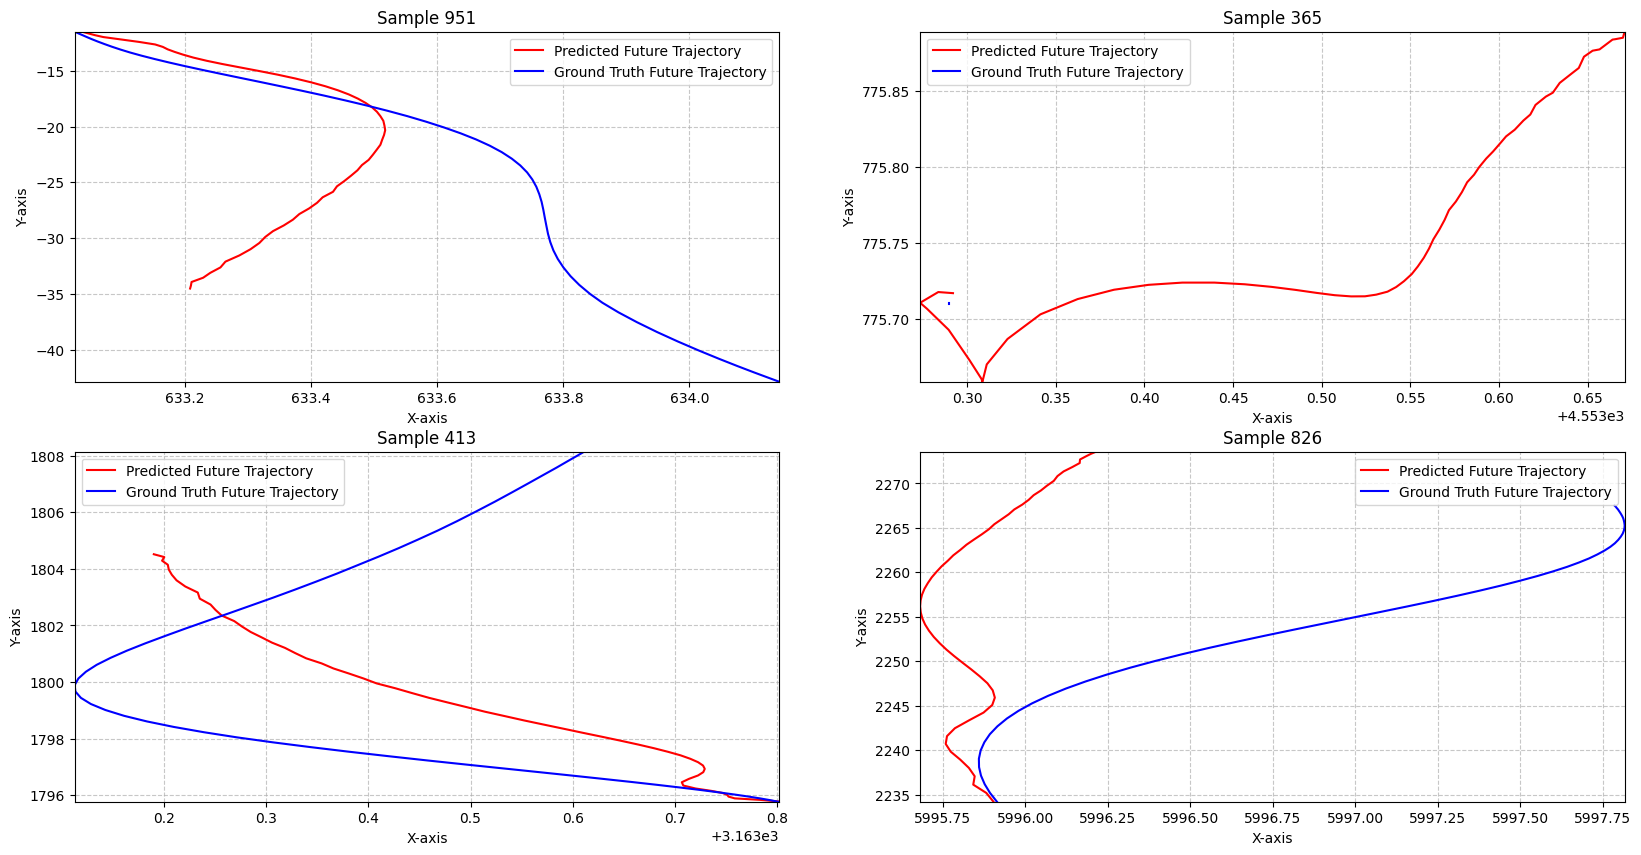

In [285]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [51]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTM().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

In [5]:
# Create directory for results if it doesn't exist
os.makedirs("grid_search_results", exist_ok=True)

LLM Assisted

In [10]:
# Function to train and validate model
def train_validate_model(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    scheduler,
    criterion,
    max_epochs,
    early_stopping_patience,
    device,
):
    best_val_loss = float("inf")
    no_improvement = 0
    train_losses = []
    val_losses = []
    val_maes = []
    val_mses = []

    for epoch in range(max_epochs):
        # ---- Training ----
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item()

        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                val_loss += criterion(pred, y).item()
                # show MAE and MSE with unnormalized data
                pred_unnorm = pred * batch.scale.view(
                    -1, 1, 1
                ) + batch.origin.unsqueeze(1)
                y_unnorm = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()

        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_mse /= len(val_dataloader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_maes.append(val_mae)
        val_mses.append(val_mse)

        if scheduler is not None:
            scheduler.step()

        # Check for early stopping
        if val_loss < best_val_loss - 1e-3:
            best_val_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= early_stopping_patience:
            break

    return {
        "best_val_loss": best_val_loss,
        "epochs_trained": epoch + 1,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_maes": val_maes,
        "val_mses": val_mses,
        "final_val_loss": val_loss,
        "final_val_mae": val_mae,
        "final_val_mse": val_mse,
    }

LLM Assisted

In [11]:
# Grid search function
def grid_search(
    train_dataloader,
    val_dataloader,
    param_grid,
    device,
    max_epochs=100,
    early_stopping_patience=10,
):
    # Generate all combinations of parameters
    param_combinations = list(itertools.product(*param_grid.values()))
    param_keys = list(param_grid.keys())

    results = []
    best_val_loss = float("inf")
    best_params = None
    best_model_state = None

    # Create a timestamp for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Create a DataFrame to store results
    results_df = pd.DataFrame(
        columns=[
            "hidden_dim",
            "num_layers",
            "dropout",
            "learning_rate",
            "weight_decay",
            "scheduler_type",
            "scheduler_param",
            "best_val_loss",
            "epochs_trained",
            "final_val_mae",
            "final_val_mse",
        ]
    )

    total_combinations = len(param_combinations)

    # Iterate through all parameter combinations
    for i, params in enumerate(param_combinations):
        param_dict = {param_keys[j]: params[j] for j in range(len(params))}

        print(f"\nGrid Search Progress: {i+1}/{total_combinations}")
        print(f"Testing parameters: {param_dict}")

        # Create model with current parameters
        model = LSTM(
            input_dim=6,
            hidden_dim=param_dict["hidden_dim"],
            num_layers=param_dict["num_layers"],
            dropout=param_dict["dropout"],
            output_dim=60 * 2,
        ).to(device)

        # Create optimizer
        optimizer = optim.Adam(
            model.parameters(),
            lr=param_dict["learning_rate"],
            weight_decay=param_dict["weight_decay"],
        )

        # Create scheduler based on type
        if param_dict["scheduler_type"] == "step":
            scheduler = optim.lr_scheduler.StepLR(
                optimizer, step_size=param_dict["scheduler_param"], gamma=0.25
            )
        elif param_dict["scheduler_type"] == "exponential":
            scheduler = optim.lr_scheduler.ExponentialLR(
                optimizer, gamma=param_dict["scheduler_param"]
            )
        elif param_dict["scheduler_type"] == "cosine":
            scheduler = optim.lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=param_dict["scheduler_param"]
            )
        elif param_dict["scheduler_type"] == "none":
            scheduler = None

        criterion = nn.MSELoss()

        # Train and validate model
        metrics = train_validate_model(
            model,
            train_dataloader,
            val_dataloader,
            optimizer,
            scheduler,
            criterion,
            max_epochs,
            early_stopping_patience,
            device,
        )

        # Store results
        result = {
            **param_dict,
            "best_val_loss": metrics["best_val_loss"],
            "epochs_trained": metrics["epochs_trained"],
            "final_val_mae": metrics["final_val_mae"],
            "final_val_mse": metrics["final_val_mse"],
            "train_losses": metrics["train_losses"],
            "val_losses": metrics["val_losses"],
            "val_maes": metrics["val_maes"],
            "val_mses": metrics["val_mses"],
        }
        results.append(result)

        # Add to DataFrame
        results_df = pd.concat(
            [
                results_df,
                pd.DataFrame(
                    [
                        {
                            "hidden_dim": param_dict["hidden_dim"],
                            "num_layers": param_dict["num_layers"],
                            "dropout": param_dict["dropout"],
                            "learning_rate": param_dict["learning_rate"],
                            "weight_decay": param_dict["weight_decay"],
                            "scheduler_type": param_dict["scheduler_type"],
                            "scheduler_param": param_dict["scheduler_param"],
                            "best_val_loss": metrics["best_val_loss"],
                            "epochs_trained": metrics["epochs_trained"],
                            "final_val_mae": metrics["final_val_mae"],
                            "final_val_mse": metrics["final_val_mse"],
                        }
                    ]
                ),
            ],
            ignore_index=True,
        )

        # Save intermediate results
        results_df.to_csv(f"grid_search_results/results_{timestamp}.csv", index=False)

        # Plot learning curves for this combination
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(metrics["train_losses"], label="Train Loss")
        plt.plot(metrics["val_losses"], label="Val Loss")
        plt.title(f"Losses\nParams: {param_dict}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(metrics["val_maes"], label="Val MAE")
        plt.title("Validation MAE")
        plt.xlabel("Epoch")
        plt.ylabel("MAE")

        plt.subplot(1, 3, 3)
        plt.plot(metrics["val_mses"], label="Val MSE")
        plt.title("Validation MSE")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")

        plt.tight_layout()
        plt.savefig(f"grid_search_results/learning_curves_{timestamp}_{i}.png")
        plt.close()

        # Update best model if better
        if metrics["best_val_loss"] < best_val_loss:
            best_val_loss = metrics["best_val_loss"]
            best_params = param_dict
            best_model_state = model.state_dict()
            torch.save(
                best_model_state, f"grid_search_results/best_model_{timestamp}.pt"
            )

    # Save final results
    results_df.to_csv(f"grid_search_results/final_results_{timestamp}.csv", index=False)

    return results, best_params, best_model_state

LLM Assisted

In [14]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define parameter grid
param_grid = {
    'hidden_dim': [64, 128, 256],
    'num_layers': [1, 2],
    'dropout': [0.0, 0.2],
    'learning_rate': [1e-2, 1e-3],
    'weight_decay': [1e-4, 1e-5],
    'scheduler_type': ['step', 'none'],
    'scheduler_param': [20]  # step_size for StepLR, gamma for ExponentialLR, T_max for CosineAnnealingLR
}

# Load your dataloaders here
# train_dataloader = ...
# val_dataloader = ...

# Execute grid search
results, best_params, best_model_state = grid_search(
    train_dataloader, 
    val_dataloader, 
    param_grid, 
    device,
    max_epochs=100,
    early_stopping_patience=10
)

# Print best parameters
print("\n=== Grid Search Complete ===")
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {results[0]['best_val_loss']:.6f}")
print(f"Best validation MAE: {results[0]['final_val_mae']:.6f}")
print(f"Best validation MSE: {results[0]['final_val_mse']:.6f}")

# Load the best model
best_model = LSTM(
    input_dim=6,
    hidden_dim=best_params['hidden_dim'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout'],
    output_dim=60 * 2
).to(device)
best_model.load_state_dict(best_model_state)

# Save the best model
torch.save(best_model.state_dict(), 'best_model_from_grid_search.pt')

best_model, best_params

Using device: cpu

Grid Search Progress: 1/96
Testing parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.0, 'learning_rate': 0.01, 'weight_decay': 0.0001, 'scheduler_type': 'step', 'scheduler_param': 20}


/var/folders/d_/qt9yhc2549s7ghqsdf91y2l40000gn/T/ipykernel_9007/3481863658.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
/var/folders/d_/qt9yhc2549s7ghqsdf91y2l40000gn/T/ipykernel_9007/3481863658.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/d_/qt9yhc2549s7ghqsdf91y2l40000gn/T/ipykernel_9007/1203000362.py:110: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat(



Grid Search Progress: 2/96
Testing parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.0, 'learning_rate': 0.01, 'weight_decay': 0.0001, 'scheduler_type': 'none', 'scheduler_param': 20}

Grid Search Progress: 3/96
Testing parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.0, 'learning_rate': 0.01, 'weight_decay': 1e-05, 'scheduler_type': 'step', 'scheduler_param': 20}

Grid Search Progress: 4/96
Testing parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.0, 'learning_rate': 0.01, 'weight_decay': 1e-05, 'scheduler_type': 'none', 'scheduler_param': 20}

Grid Search Progress: 5/96
Testing parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.0, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'scheduler_type': 'step', 'scheduler_param': 20}

Grid Search Progress: 6/96
Testing parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.0, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'scheduler_type': 'none', 'scheduler_param': 20}

Grid Search Progres

NameError: name 'plot_comparative_results' is not defined

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B

In [18]:
# Load the best model
best_model = LSTM(
    input_dim=6,
    hidden_dim=128,
    num_layers=1,
    dropout=0.2,
    output_dim=60 * 2,
)
best_optimizer = optim.Adam(
        model.parameters(),
        lr=0.01,
        weight_decay=1e-05,
)
best_scheduler = optim.lr_scheduler.StepLR(
    optimizer, step_size=20, gamma=0.25
)
best_model.load_state_dict(
    torch.load(
        "./grid_search_results/best_model_20250508_152210.pt",
        weights_only=True,
    )
)


# Save the best model
torch.save(best_model.state_dict(), "best_model_from_grid_search.pt")

In [23]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=lambda xs: Batch.from_data_list(xs),
)

best_model = torch.load("best_model_from_grid_search.pt")
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTM().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)

        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=["x", "y"])
output_df.index.name = "index"
output_df.to_csv("submission.csv", index=True)